In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CS/new_data_urls.csv')
df.head()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [4]:
print(len(df[df['status']==0]), len(df[df['status']==1]))
df_maj, df_min = df[df['status']==1], df[df['status']==0]
df_maj_sampled = df_maj.sample(len(df_min), random_state=42)
df_balanced = pd.concat([df_maj_sampled, df_min])
print(len(df_balanced[df_balanced['status']==0]), len(df_balanced[df_balanced['status']==1]))
df_balanced.reset_index(inplace=True, drop=True)
df_balanced

394982 427028
394982 394982


,url,status
0,barrybartlett.net/,1
1,archive.org/stream/cihm_03838/cihm_03838_djvu.txt,1
2,strategyfirst.net/,1
3,www.macminute.com/headlines.xml,1
4,vrealities.com/sensio.html,1
...,...,...
789959,zzufg.com,0
789960,zzu.li,0
789961,zzz.co.uk,0
789962,zzzoolight.co.za,0


In [5]:
pip install seaborn


<ipython-input-6-c856445b5bb8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


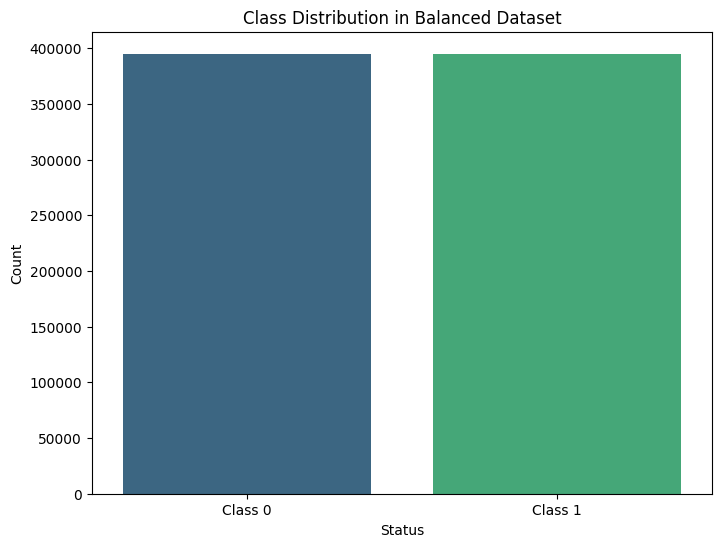

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_balanced is already created as shown in your previous code

# Count the occurrences of each class
class_counts = df_balanced['status'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Balanced Dataset')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])  # Customize x-axis labels
plt.show()


In [7]:
df_balanced['status'].value_counts()

,count
status,
1,394982
0,394982


# Utils

We use word tokenize

In [8]:
def tok(string) -> str:
    return string.replace('/', '.').split('.')

def to_txt(text) -> str:
    return text.replace('.', ' ').replace('/', ' ')

It define top terms as the most frequency in the copus (documents).
$$
have(doc, term) = \begin{cases}
    1,& \text{if} \ term \subseteq doc \\
    0,& \text{otherwise}
\end{cases}
$$
\
\
$$top(documents, terms, n) = \max_n \sum_{doc \ \in \ documents \\ term \ \in \ terms}{have(doc, term)}$$

In [9]:
def top_terms(df, n) -> list[str]:
    term = {}
    for url, status in df.values:
        for word in tok(url):
            if word != '':
                if word not in term.keys():
                    term[word] = 0

                term[word]+=1

    return [t[0] for t in sorted(term.items(), key=lambda x:x[1], reverse=True)[:n]]

In [10]:
def num_digits(text) -> int:
    return len(re.findall('\d', text))

def num_dots(text) -> int:
    return len(re.findall('\.', text))

def num_bar(text) -> int:
    return len(re.findall('/', text))

# Vocabulary

In [11]:
VOC = top_terms(df_balanced, n=10)
VOC

['com', 'https:', 'www', 'html', 'http:', 'org', 'net', 'cn', 'php', 'index']

# Corpus

In [12]:
CORPUS = [to_txt(URLs) for URLs in df_balanced.url]
CORPUS[101]

'answers com topic leveille'

# Vetorizer urls and generate data for each document (index)

In [13]:
vectorizer = CountVectorizer(binary=True, vocabulary=VOC)
docTermMatrix = vectorizer.fit_transform(CORPUS)

matrix = pd.DataFrame(docTermMatrix.A, columns=VOC)
matrix['dots'] = [num_dots(text) for text in df_balanced.url]
matrix['bar'] = [num_bar(text) for text in df_balanced.url]
matrix['len'] = [len(text) for text in CORPUS]
matrix['digits'] = [num_digits(text) for text in CORPUS]
matrix

,com,https:,www,html,http:,org,net,cn,php,index,dots,bar,len,digits
0,0,0,0,0,0,0,1,0,0,0,1,1,18,0
1,0,0,0,0,0,1,0,0,0,0,2,3,49,10
2,0,0,0,0,0,0,1,0,0,0,1,1,18,0
3,1,0,1,0,0,0,0,0,0,0,3,1,31,0
4,1,0,0,1,0,0,0,0,0,0,2,1,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789959,1,0,0,0,0,0,0,0,0,0,1,0,9,0
789960,0,0,0,0,0,0,0,0,0,0,1,0,6,0
789961,0,0,0,0,0,0,0,0,0,0,2,0,9,0
789962,0,0,0,0,0,0,0,0,0,0,2,0,16,0


---
**Okay, but: which attribute is more important? To solve this problem I use a decision tree. The Decision Tree is a machine learning model that allows you to visualize the combinations of attributes for the class.**

# **Proposed**

Accuracy: 0.9286
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     79122
           1       0.96      0.90      0.93     85280

    accuracy                           0.93    164402
   macro avg       0.93      0.93      0.93    164402
weighted avg       0.93      0.93      0.93    164402

Confusion Matrix:
 [[75706  3416]
 [ 8317 76963]]


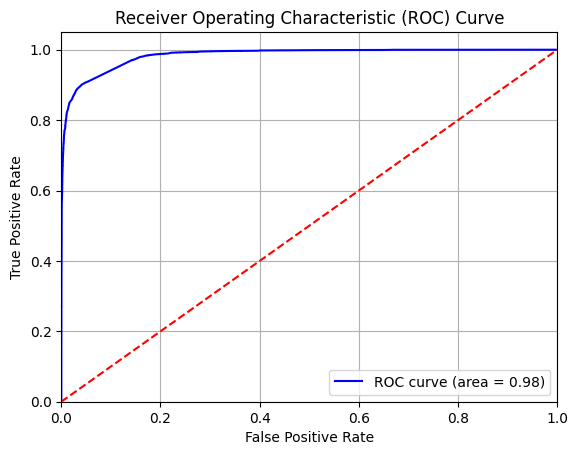

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Replace with your actual dataset

# Example data preparation
vectorizer = TfidfVectorizer(max_features=9000)
X = vectorizer.fit_transform(df['url'])
y = df['status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_reg = LogisticRegression(solver='liblinear', random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (soft voting)
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('lr', log_reg),
    ('gb', gb_model)
], voting='soft') # Changed from 'hard' to 'soft'

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
y_prob = ensemble_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

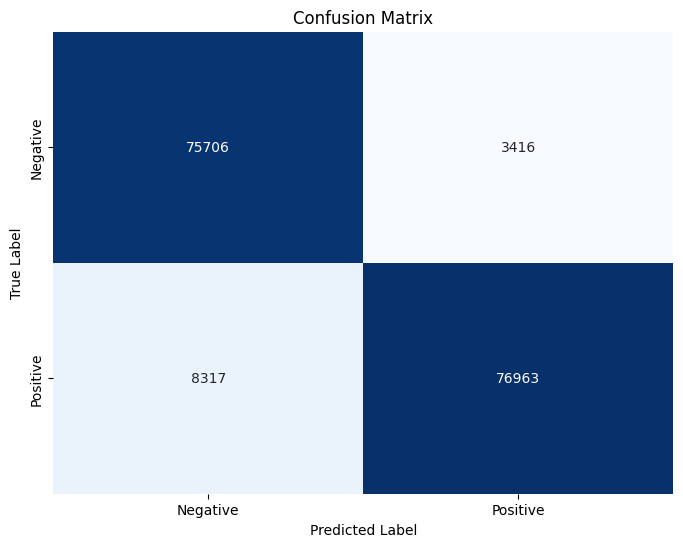

In [ ]:
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Decision Tree

In [14]:
X_train, X_test, y_train, y_test = train_test_split(matrix.values, df_balanced['status'].values, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8821530067787814

In [16]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[69214,  9790],
       [ 8829, 70160]])

In [ ]:
# plot_tree(clf, max_depth=2, feature_names=matrix.columns, class_names=['phishing', 'clean'],
#           fontsize=7)
# plt.figure(figsize=(30, 30))
# plt.show()

**has a high probability of being phishing!!!:**

- If it has no slash and the text size is greater than 19

- Even if there is the slash character, if the number of points is greater than 3 and the text has the string 'html'

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("Decision tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision tree Accuracy: 0.8821530067787814
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     79004
           1       0.88      0.89      0.88     78989

    accuracy                           0.88    157993
   macro avg       0.88      0.88      0.88    157993
weighted avg       0.88      0.88      0.88    157993



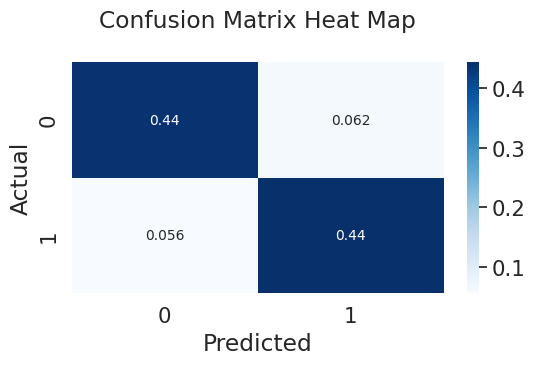

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

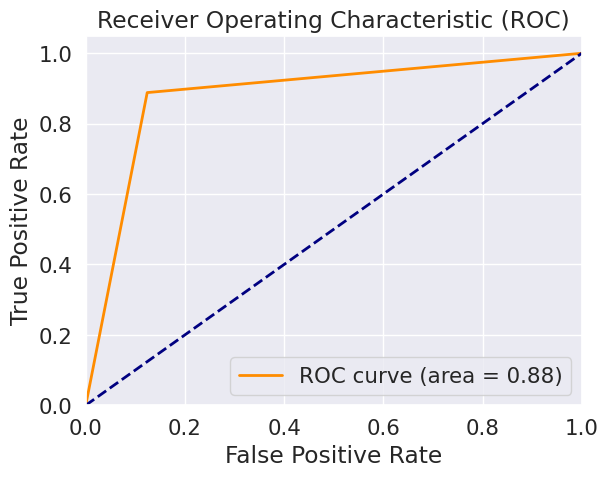

AUC Score: 0.925623532293029


In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
y_prob = clf.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print("AUC Score:", roc_auc_score(y_test, y_prob))

# **Random Forest**

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8881406138246631
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     79004
           1       0.88      0.90      0.89     78989

    accuracy                           0.89    157993
   macro avg       0.89      0.89      0.89    157993
weighted avg       0.89      0.89      0.89    157993



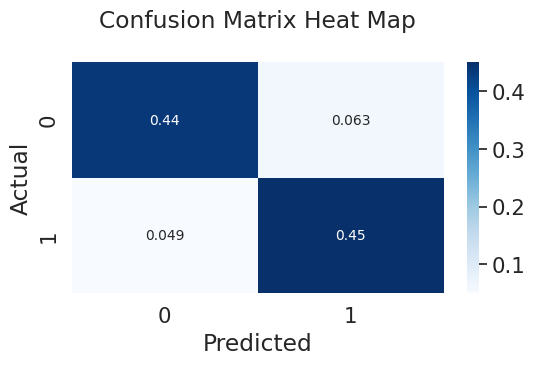

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred_rf, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

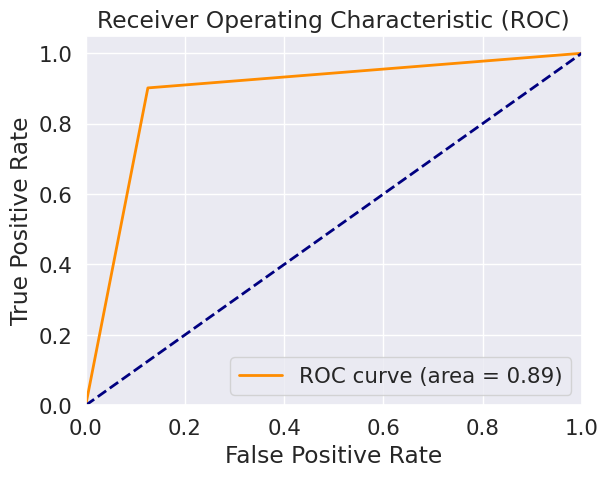

AUC Score: 0.8881418849608438


In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print("AUC Score:", roc_auc_score(y_test, y_pred_rf))

# SVM

In [ ]:
from sklearn.svm import SVC

# Create and train the SVM model (use a linear kernel or try 'rbf' for non-linear)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_rf))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred_svm, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred_nb, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print("AUC Score:", roc_auc_score(y_test, y_pred_nb))

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k = 2
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred_knn, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print("AUC Score:", roc_auc_score(y_test, y_pred_knn))

# LSVC

In [ ]:
from sklearn.svm import LinearSVC

# LinearSVC model
lsvc_model = LinearSVC()
lsvc_model.fit(X_train, y_train)

# Predict labels
y_pred_lsvc = lsvc_model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression evaluation
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_lsvc))
print(classification_report(y_test, y_pred_lsvc))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data = confusion_matrix(y_test, y_pred_lsvc, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lsvc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print("AUC Score:", roc_auc_score(y_test, y_pred_lsvc))